In [ ]:
# Install XGBoost
!pip install xgboost

# Install TensorFlow (if you haven't already)
!pip install tensorflow

In [ ]:
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# In Colab, after uploading to the sidebar, files are in the root directory
train = pd.read_csv('train.csv')
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

print("Data Loaded Successfully")

Data Loaded Successfully


In [ ]:
feature_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment']
for col in feature_cols:
    features[col].fillna(features[col].median(), inplace=True)

data = pd.merge(train, stores, on='Store', how='left')
data = pd.merge(data, features, on=['Store', 'Date', 'IsHoliday'], how='left')

data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week

agg_data = data.groupby(['Store', 'Dept'])['Weekly_Sales'].agg(['min', 'max', 'mean', 'median', 'std']).reset_index()
data = pd.merge(data, agg_data, on=['Store', 'Dept'], how='left')
data['std'].fillna(0, inplace=True)

data['Total_MarkDown'] = data[['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']].sum(axis=1)
data = data[data['Weekly_Sales'] >= 0]

z_scores = np.abs(stats.zscore(data['Weekly_Sales']))
data = data[(z_scores < 3)]

data_encoded = pd.get_dummies(data, columns=['Store', 'Dept', 'Type'])

X_all = data_encoded.drop(['Weekly_Sales', 'Date'], axis=1)
y_all = data_encoded['Weekly_Sales']

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_all), columns=X_all.columns)

target_features = [
    'mean', 'median', 'Week', 'Temperature', 'max', 'CPI', 'Fuel_Price',
    'min', 'std', 'Unemployment', 'Month', 'Total_MarkDown', 'IsHoliday',
    'Size', 'Year', 'Dept_16', 'Dept_18', 'Dept_3', 'Dept_9', 'Dept_11',
    'Dept_1', 'Dept_5', 'Dept_56'
]

existing_cols = [col for col in target_features if col in X_scaled.columns]
X_final = X_scaled[existing_cols]

X_train, X_test, y_train, y_test = train_test_split(X_final, y_all, test_size=0.2, random_state=42)
print("Preprocessing Complete")

/tmp/ipython-input-2637870726.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features[col].fillna(features[col].median(), inplace=True)
/tmp/ipython-input-2637870726.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

Preprocessing Complete


In [ ]:
print("Running Linear Regression...")
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
acc_lr = r2_score(y_test, pred_lr)
print(f"Linear Regression R2: {acc_lr}")

print("Running Random Forest...")
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)
acc_rf = r2_score(y_test, pred_rf)
print(f"Random Forest R2: {acc_rf}")

print("Running KNN...")
knn = KNeighborsRegressor(n_neighbors=1, n_jobs=-1)
knn.fit(X_train, y_train)
pred_knn = knn.predict(X_test)
acc_knn = r2_score(y_test, pred_knn)
print(f"KNN R2: {acc_knn}")

print("Running XGBoost...")
xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, n_jobs=-1)
xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
acc_xgb = r2_score(y_test, pred_xgb)
print(f"XGBoost R2: {acc_xgb}")

Running Linear Regression...
Linear Regression R2: 0.9244074057069073
Running Random Forest...
Random Forest R2: 0.9798081882082165
Running KNN...
KNN R2: 0.9463072677991328
Running XGBoost...
XGBoost R2: 0.9641525320446959


In [ ]:
print("Running RNN...")
X_train_rnn = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_rnn = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, X_train.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_rnn, y_train, epochs=50, batch_size=128, verbose=1)

pred_rnn = model.predict(X_test_rnn)
acc_rnn = r2_score(y_test, pred_rnn)
print(f"RNN R2: {acc_rnn}")

Running RNN...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2572/2572 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 479602144.0000
Epoch 2/50
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 476209344.0000
Epoch 3/50
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 473844128.0000
Epoch 4/50
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 470702080.0000
Epoch 5/50
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 467847552.0000
Epoch 6/50
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 464832448.0000
Epoch 7/50
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 459809312.0000
Epoch 8/50
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 461973408.0000
Epoch 9/50
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 456288032.0000
Epoch 10/50
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 457597440.0000
Epoch 11/50
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 453543840.0000
Epoch 12/50
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 451661472.0000
Epoch 13/50
2572/2572 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 44843289

               Model  Accuracy
1      Random Forest  0.979808
3            XGBoost  0.964153
2                KNN  0.946307
0  Linear Regression  0.924407
4                RNN -0.261982


/tmp/ipython-input-1323581500.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=models, palette='viridis')


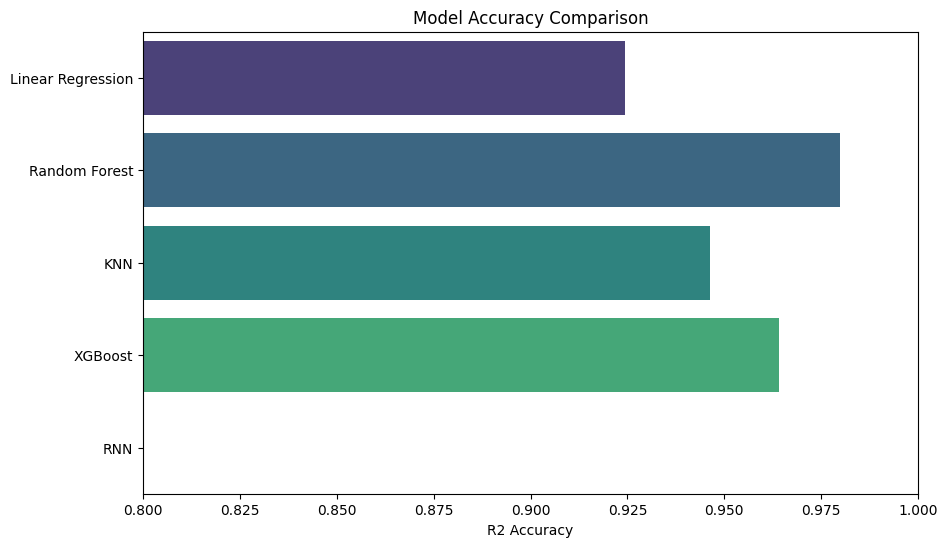

In [ ]:
models = ['Linear Regression', 'Random Forest', 'KNN', 'XGBoost', 'RNN']
scores = [acc_lr, acc_rf, acc_knn, acc_xgb, acc_rnn]

comparison = pd.DataFrame({'Model': models, 'Accuracy': scores})
print(comparison.sort_values(by='Accuracy', ascending=False))

plt.figure(figsize=(10, 6))
sns.barplot(x=scores, y=models, palette='viridis')
plt.xlabel('R2 Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0.8, 1.0)
plt.show()

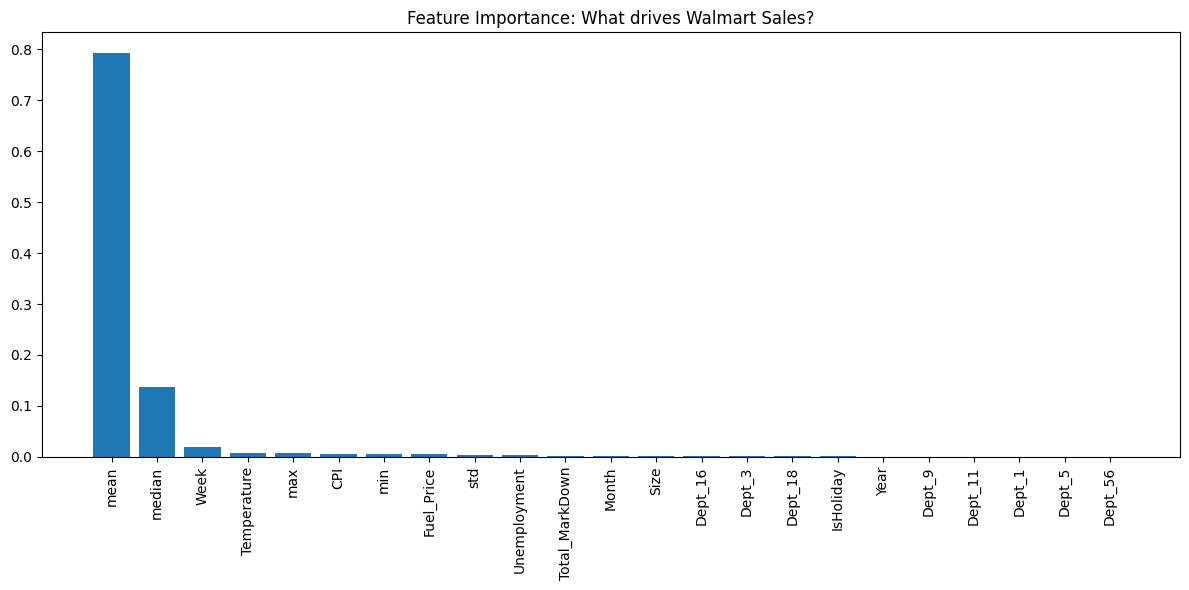

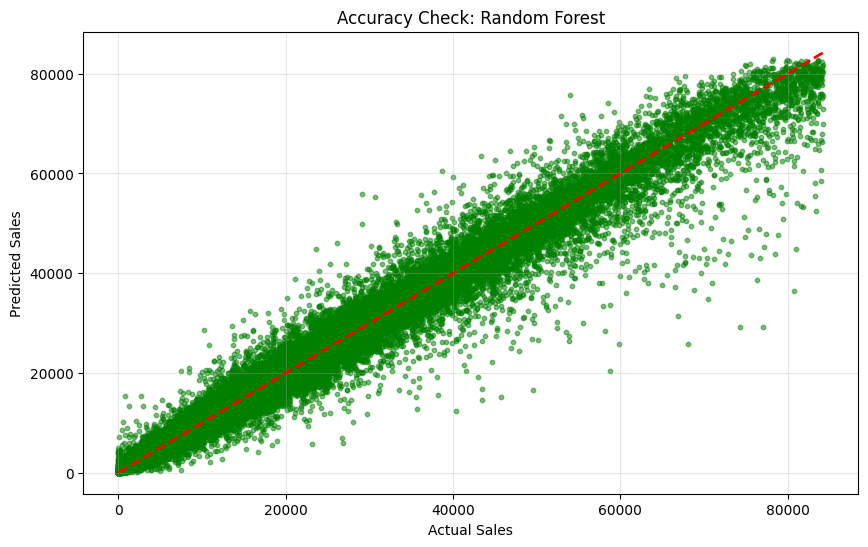

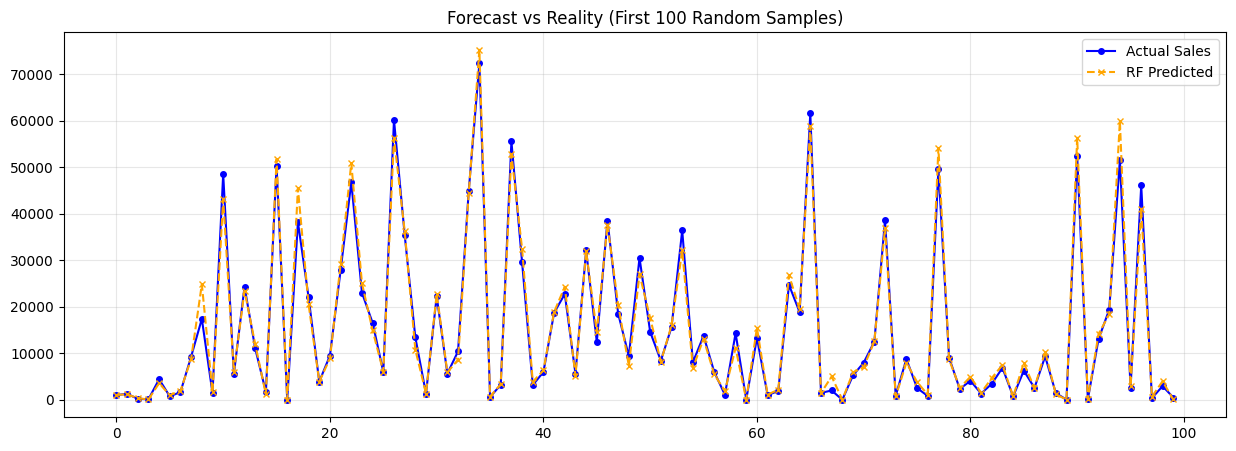

In [ ]:
# --- Visualization for the Random Forest Model ---
import matplotlib.pyplot as plt
import numpy as np

# 1. Feature Importance Plot
plt.figure(figsize=(12, 6))
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.title('Feature Importance: What drives Walmart Sales?')
plt.bar(range(X_train.shape[1]), importances[indices], align='center', color='#1f77b4')
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

# 2. Actual vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, pred_rf, alpha=0.5, color='green', s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Accuracy Check: Random Forest')
plt.grid(True, alpha=0.3)
plt.show()

# 3. Prediction Snapshot (First 100 Samples)
plt.figure(figsize=(15, 5))
plt.plot(y_test.values[:100], label='Actual Sales', color='blue', marker='o', markersize=4)
plt.plot(pred_rf[:100], label='RF Predicted', color='orange', linestyle='--', marker='x', markersize=4)
plt.title('Forecast vs Reality (First 100 Random Samples)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()